# CMPE 462 - Project 3
## Logistic Matrix Factorization

**Student IDs:** 2015300000 - 2015300210

## Problem Description

Binary matrices (Matrices with elements of 0/1) appear in many applications. A binary matrix can represent relations such as 'User $i$ bought item $j$', or 'Member $i$ likes Member $j$'. Such datasets are often sparse -- only a fraction of the possible entries of a matrix are known. 

A binary matrix can also viewed as the adjacency matrix of a bipartite graph. Hence each entry corresponds to an edge.
One task here is known as link prediction, meaning guessing the presence or absence of edges in the underlying graph. 
This prediction can then be used for several tasks such as recommendation or knowledge-base completion.

In this project, you are going to implement a matrix factorization with missing elements using Stochastic Gradient Descent (SGD), Batch SGD and GD first in numpy, then also making use of PyTorch. You will also analyze the effect of the fraction of missing elements, estimation rank and max iteration. 

The matrix you will factorize is a binary(logistic) matrix and has a specific pattern. Its elements that whose indices sum up to an even number are 1 and 0 otherwise. For more detailed derivation and problem description, you can analyze [this](https://github.com/atcemgil/notes/blob/master/Logistic%20Matrix%20Factorization.ipynb) notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [9]:
def sigmoid(t):
    return 1./(1+np.exp(-t))

# Dataset Generation

This cell generates the dataset as we have discussed. It sets the elements whom indices sum up to even number to 1.

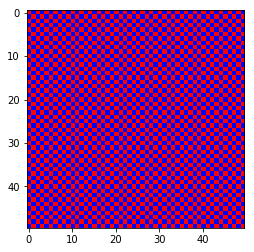

In [2]:
#Create the synthetic data here.
M = 50
original_matrix = np.zeros((M,M))
for i in range(M):
    for j in range(M):
        condition = int(i+j)%2 == 0
        
        if condition:
            original_matrix[i,j] = 1

plt.imshow(original_matrix, cmap ='bwr')
plt.show()

# Masking

Now mask the dataset. Number of elements to mask is set by a parameter. 

Seed the random for repeatability

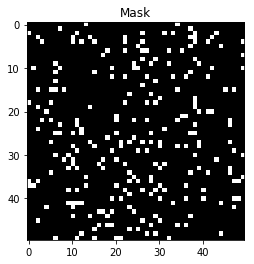

In [3]:
#Define the mask generating function and create a mask. Then visualize it.
random.seed(10)
def generate_mask(M = 50, mask_count=M*M//10):
    masks = [(random.randint(0,M-1), random.randint(0,M-1)) for i in range(mask_count)]
    mask = np.ones((M,M))
    for m in masks:
        mask[m] = False   
    return mask

Mask = generate_mask(M)
plt.imshow(Mask, cmap='binary')  
plt.title('Mask')
plt.show()

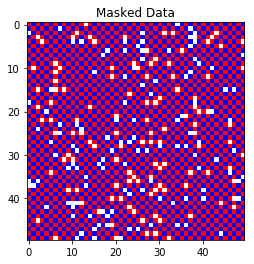

In [5]:
#Plot the masked matrix.
masked_matrix = original_matrix.copy()
masked_matrix[Mask == False] = np.nan
plt.imshow(masked_matrix, cmap='bwr')
plt.title("Masked Data")
plt.show()

# Gradient Descents

Implement **SGD**. **BGD** and **GD** in this cell using **numpy**. Compute the error of the resulting matrix compared to original data for approximation ranks in [1,M]. For measuring the quality of the fit, you should use the log-likelihood

\begin{eqnarray}
\log p(Y |W, H ) &=& \sum_j \sum_{i} M(i,j) Y(i,j) \left(\sum_k W(i,k) H(k,j)\right)  - \sum_j \sum_{i} M(i,j) \log\left( 1+ \exp\left(\sum_k W(i,k) H(k,j)\right)\right) 
\end{eqnarray}

For plot generation, use results computed by SGD.

In [7]:
#Define the gradient descent function for logistic matrix factorization. Set batch size with parameter B.
#For sgd set B=1. For gradient descent set GD=1. If you want log likelihood printed out, set PRINT=1 and adjust the period.
def sgd(Y, K, Mask, eta=0.005, nu=0.1, MAX_ITER = 10000, PRINT_PERIOD=500, B=1, GD=0, PRINT=1):
    M = Y.shape[0]
    N = Y.shape[1]
    
    W = np.random.randn(M,K)
    H = np.random.randn(K,N)
    
    YM = Y.copy()
    YM[Mask == False] = 0
    
    
    
    if GD==0:
        
        for epoch in range(MAX_ITER):
            index_list = [(random.randint(0,M-1), random.randint(0,M-1)) for i in range(B)]
            dLh = np.zeros(K)
            dLw = np.zeros(K)
            
            for index in index_list:
                dLh = dLh + YM[index[0],index[1]]*(Y[index[0],index[1]] - sigmoid(np.dot(W[index[0],:],H[:,index[1]])))*W[index[0],:].T - nu*H[:,index[1]]
                dLw = dLw + YM[index[0],index[1]]*(Y[index[0],index[1]] - sigmoid(np.dot(W[index[0],:],H[:,index[1]])))*H[:,index[1]].T - nu*W[index[0],:]
            dLh = dLh/B
            dLw = dLw/B
            
            H[:,index[1]] = H[:,index[1]] + eta*dLh
            W[index[0],:] = W[index[0],:] + eta*dLw
            
        
            if epoch % PRINT_PERIOD == 0:
                LL = np.sum( (YM*np.log(sigmoid(np.dot(W,H))) +  (Mask-YM)*np.log(1 - sigmoid(np.dot(W,H)))) ) - nu*np.sum(H**2)/2. - nu*np.sum(W**2)/2. 
                if PRINT==1:
                    print(epoch, LL)
    else:
        for epoch in range(MAX_ITER):
            dLh = np.dot(W.T, YM-Mask*sigmoid(np.dot(W,H))) - nu*H
            H = H + eta*dLh
            dLw = np.dot(YM-Mask*sigmoid(np.dot(W,H)),H.T ) - nu*W
            W = W + eta*dLw

            if epoch % PRINT_PERIOD == 0:
                LL = np.sum( (YM*np.log(sigmoid(np.dot(W,H))) +  (Mask-YM)*np.log(1 - sigmoid(np.dot(W,H)))) ) - nu*np.sum(H**2)/2. - nu*np.sum(W**2)/2. 
                if PRINT==1:
                    print(epoch, LL)
            
        
    return W,H,LL



Plot error vs estimation rank.

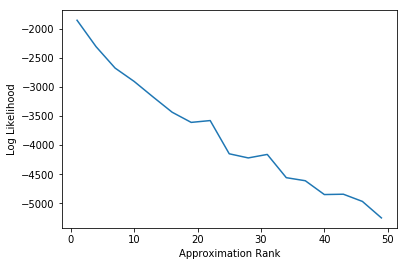

In [48]:
# Plot the log Likelihood vs Approximation Rank
# Lower ranks seem to work better.
errors = []
for i in range(1, M+1,3):
    W,H,LL = sgd(original_matrix, i, Mask, MAX_ITER=10000,eta = 0.005,GD=0,PRINT=0)
    errors.append(LL)
plt.plot(range(1,M+1,3), errors)
plt.xlabel('Approximation Rank')
plt.ylabel('Log Likelihood')
plt.show()

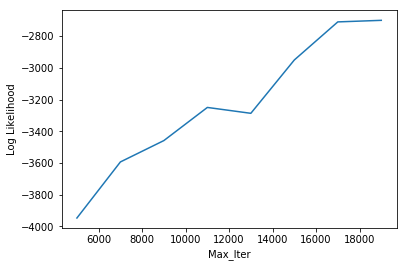

In [13]:
errors = []
for i in range(5000, 20000 ,2000):
    W,H,LL = sgd(original_matrix, 20, Mask, MAX_ITER= i, PRINT =0)
    errors.append(LL)
plt.plot(range(5000, 20000, 2000), errors)
plt.xlabel('Max_Iter')
plt.ylabel('Log Likelihood')
plt.show()

Now compute error for both changing rank( 1 to M) and max_iter(5000-20000). Plot it as a heatmap. You can use the plotting code below.

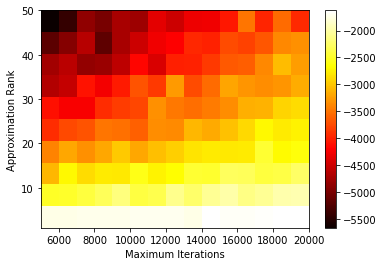

In [15]:
#Plot the likelihood for different approximation and maximum iteration combinations.
#The results agree with the last two plots above.
errors = np.zeros((len(range(1,M+1,5)),len(range(5000,20000,1000))))

for i,max_iter in enumerate(range(5000,20000,1000)):
    for j,rank in enumerate(range(1,M+1,5)):
        W,H,LL = sgd(original_matrix, rank, Mask = Mask, MAX_ITER=max_iter,PRINT=0)    
        errors[j,i]=LL

plt.imshow(errors, cmap='hot', interpolation='nearest', extent=[5000,20000,1,M], aspect='auto',origin='lower')
plt.xlabel('Maximum Iterations')
plt.ylabel('Approximation Rank')
plt.colorbar()
plt.show()

Now analyze the effect of varying the hidden element count(set your own limits) and approximation rank

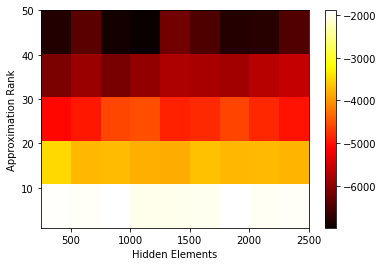

In [17]:
#The effect of approximation rank is same as before, but there is no clear pattern regarding the number of hidden elements.
errors = np.zeros((len(range(1,M+1,10)),len(range(250,2500,250))))

for i,mask in enumerate(range(250,2500,250)):
    Mask= generate_mask(M=50,mask_count=i)
    for j,rank in enumerate(range(1,M+1,10)):
        W,H,LL = sgd(original_matrix, rank, Mask = Mask, MAX_ITER=1000,PRINT=0)    
        errors[j,i]=LL

plt.imshow(errors, cmap='hot', interpolation='nearest', extent=[250,2500,1,M], aspect='auto',origin='lower')
plt.xlabel('Hidden Elements')
plt.ylabel('Approximation Rank')
plt.colorbar()
plt.show()

# PyTorch

Now implement BGD and SGD using PyTorch and generate the same plots.

In [18]:
import torch
from torch.autograd import Variable

In [22]:
sigmoid_f = torch.nn.Sigmoid()

In [35]:
def gd(Y,K,Mask,max_iter,eta):
    Mask = Variable(torch.from_numpy(Mask).double()).float()
    
    M = Y.shape[0]
    YM = Y.copy()
    
    YM[Mask == False] = 0
    YM = Variable(torch.from_numpy(YM).double())
    YM = YM.float()
    
    W = Variable(torch.rand(M,K),requires_grad=True).float()
    H = Variable(torch.rand(K,M),requires_grad=True).float()
    
    LL = torch.sum( (YM*torch.log(sigmoid_f(torch.matmul(W,H))) + (Mask-YM)*torch.log(1 - sigmoid_f(torch.matmul(W,H)))) ).double()
    for i in range(max_iter):
        if i == max_iter-1:
            LL.backward()

            W.data.add_(eta*W.grad.data)
            H.data.add_(eta*H.grad.data)

            W.grad.zero_()
            H.grad.zero_()
        else:
            LL.backward(retain_graph=True)

            W.data.add_(eta*W.grad.data)
            H.data.add_(eta*H.grad.data)

            W.grad.zero_()
            H.grad.zero_()
    return W,H,LL

In [38]:
errors=[]
for i in range(1,M+1,5):
        w,h,ll = gd(original_matrix,K=i,Mask=Mask,max_iter=1000,eta=0.01)
        errors.append(ll)

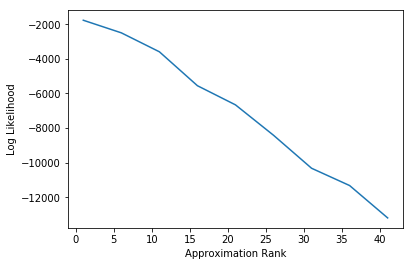

In [39]:
plt.plot(range(1,M+1,5), errors)
plt.xlabel('Approximation Rank')
plt.ylabel('Log Likelihood')
plt.show()

In [28]:
errors = np.zeros((len(range(100,2000,200)),len(range(1,M+1,10))))
for j,rank in enumerate(range(1,M+1,10)):
    for i,max_iter in enumerate(range(100,2000,200)):
        W,H,LL = gd(original_matrix,K=rank,Mask=Mask,max_iter=max_iter,eta=0.01)    
        errors[i,j]=LL

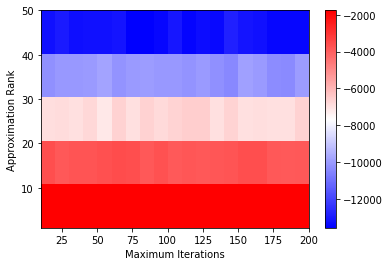

In [45]:
errors = np.zeros((len(range(1,M+1,10)),len(range(10,200,10))))

for i,max_iter in enumerate(range(10,200,10)):
    for j,rank in enumerate(range(1,M+1,10)):
        W,H,LL = gd(original_matrix, rank, Mask = Mask, max_iter=max_iter,eta=0.01)    
        errors[j,i]=LL

plt.imshow(errors, cmap='bwr', interpolation='nearest', extent=[10,200,1,M], aspect='auto',origin='lower')
plt.xlabel('Maximum Iterations')
plt.ylabel('Approximation Rank')
plt.colorbar()
plt.show()